In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, roc_curve, precision_recall_curve,precision_score, f1_score

In [2]:
# Read dataset to pandas dataframe
df = pd.read_csv('cookies_train.csv')
print(df.shape)
df.head()

(1738, 134)


,Italian seasoning,Worcestershire sauce,allspice,almonds,anchovies,anise,apples,apricots,arugula,bacon,...,vanilla,vinegar,wafer cookies,walnuts,water,whipping cream,wine,yeast,zucchini,class
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Cookies
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Cookies
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,Cookies
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Cookies
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Cookies


In [3]:
X = df.iloc[:, :-1] # u X smo stavili sva obelezja osim poslednje kolone
y = df.iloc[:, -1] # stavili smo poslednju kolonu

In [4]:
print('nedostajućih vrednosti ima: ', X.isnull().sum().sum())
print('oznake klasa su: ', y.unique())
print('uzoraka u prvoj klasi ima: ', sum(y=='Cookies'))
print('uzoraka u drugoj klasi ima: ', sum(y=='Pastries'))
print('uzoraka u trecoj klasi ima: ', sum(y=='Pizzas'))

nedostajućih vrednosti ima:  0
oznake klasa su:  ['Cookies' 'Pastries' 'Pizzas']
uzoraka u prvoj klasi ima:  723
uzoraka u drugoj klasi ima:  619
uzoraka u trecoj klasi ima:  396


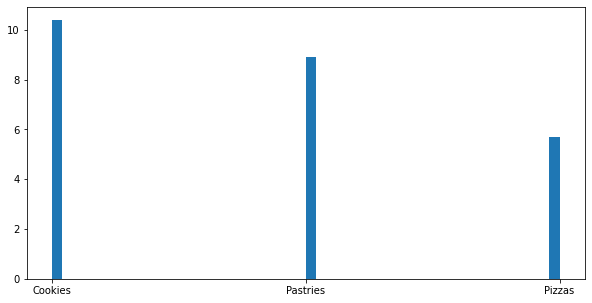

In [5]:
plt.figure(figsize=(10,5))
plt.hist(y, density=True, bins=50)
plt.show()

# vidimo da klase nisu jednako zastupljene, moracemo da pazimo kod testiranja

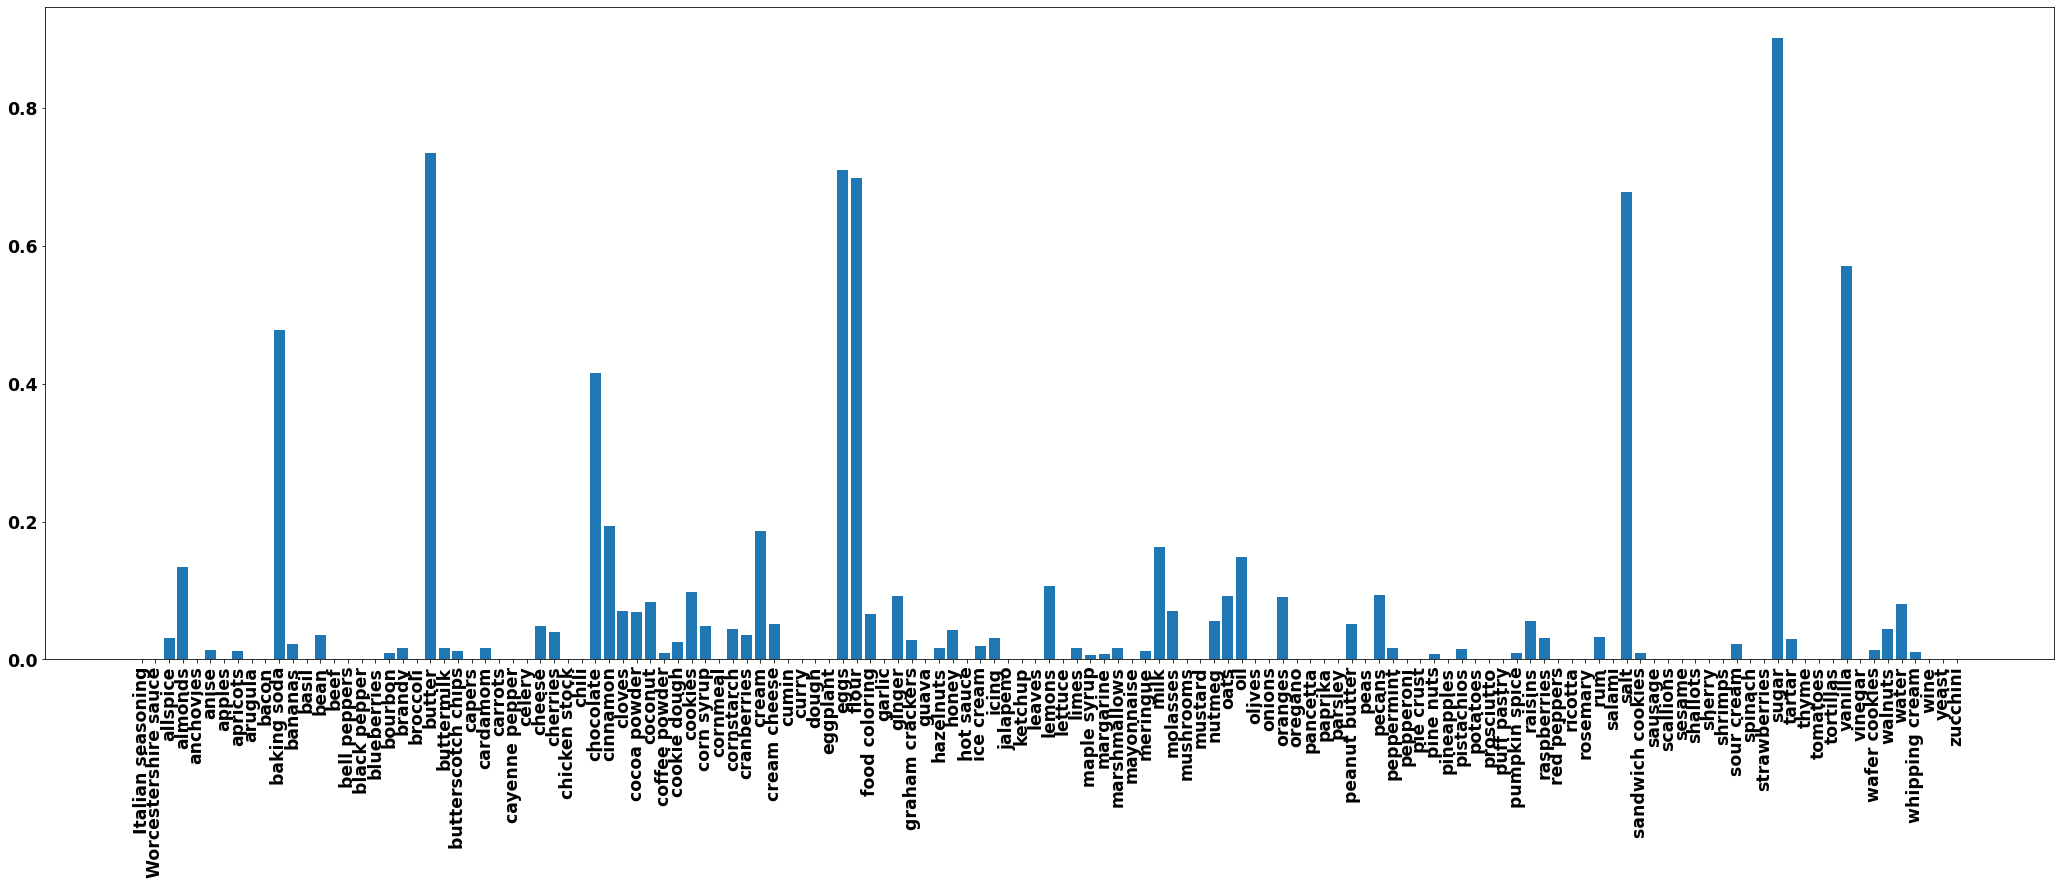

In [6]:
df_cookies=X.loc[y=='Cookies',:]

plt.figure(figsize=(36, 12))
plt.bar(np.arange(len(df_cookies.columns)), df_cookies.sum()/len(df_cookies.index))
ind = np.argsort(df_cookies.sum())
plt.xticks(ind, df_cookies.columns[ind], rotation='vertical', fontweight='bold', fontsize='xx-large')
plt.yticks(fontweight='bold', fontsize='xx-large')
plt.show()

# primecujemo da postoje neki sastojci koji se ucestalo javljaju u ovoj klasi
# prasak za pecivo, puter, cokolada, jaja, brasno, so, secer, vanila

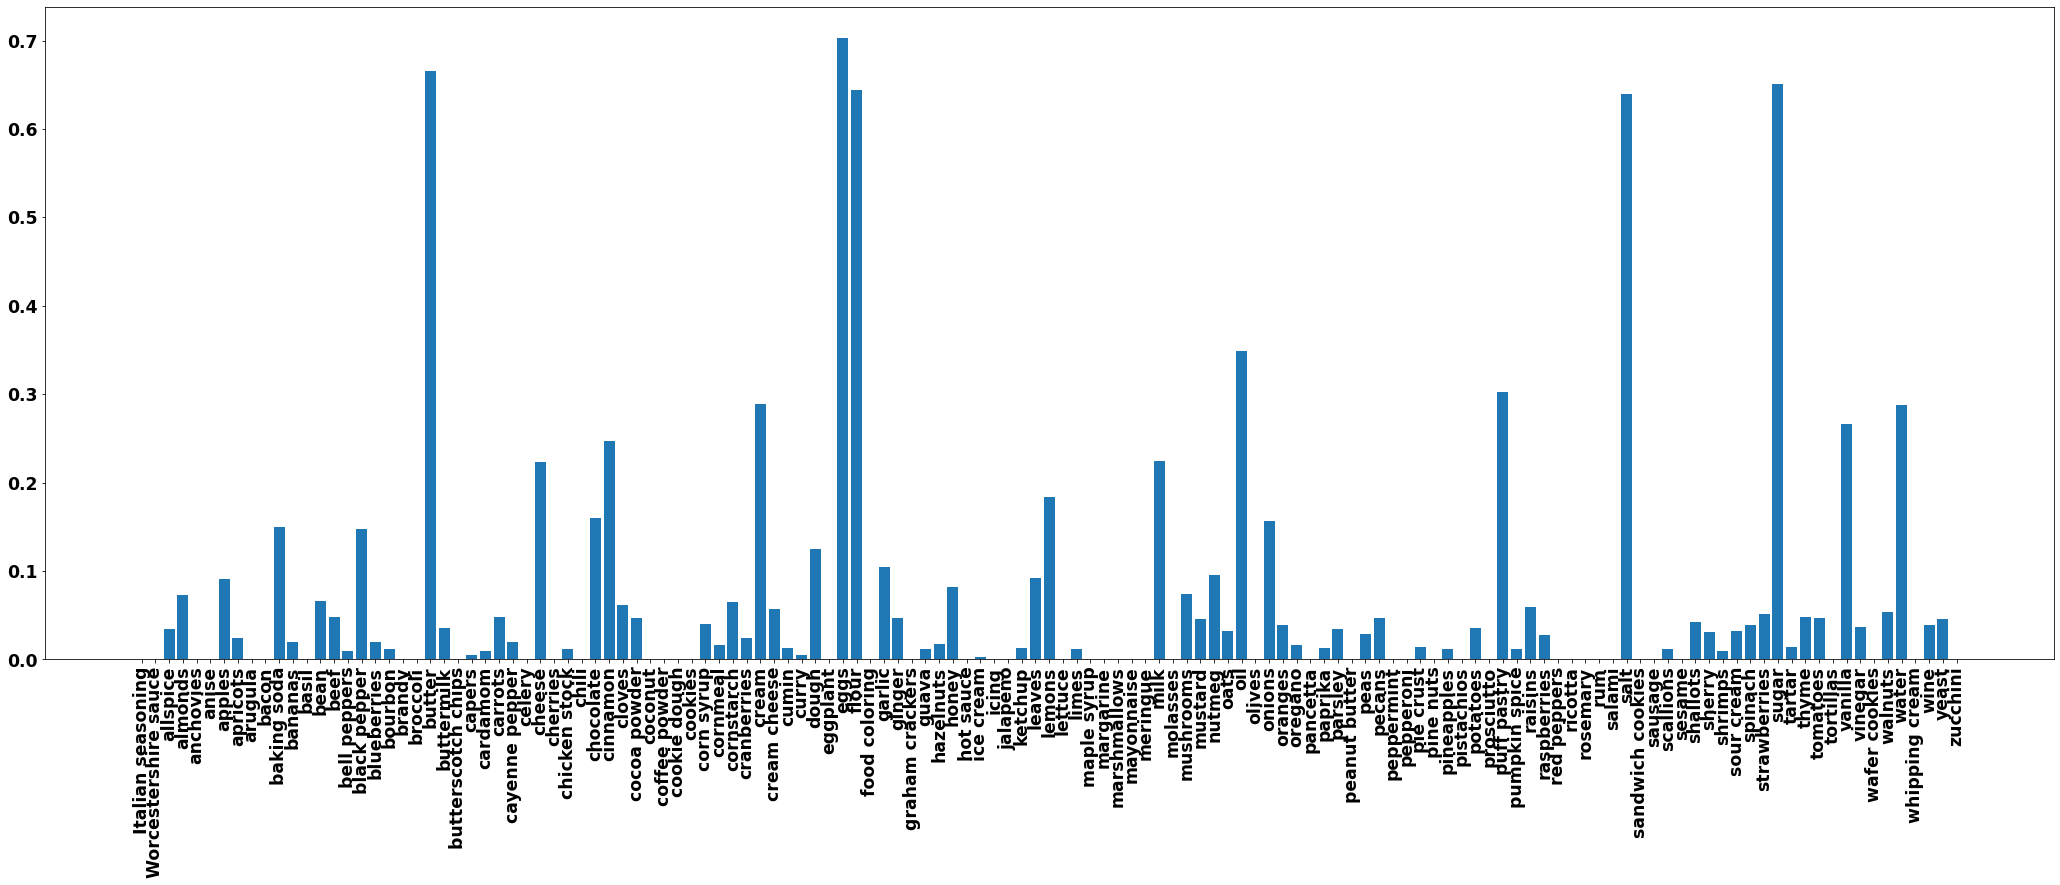

In [7]:
df_pastries=X.loc[y=='Pastries',:]

plt.figure(figsize=(36, 12))
plt.bar(np.arange(len(df_pastries.columns)), df_pastries.sum()/len(df_pastries.index))
ind = np.argsort(df_pastries.sum())
plt.xticks(ind, df_pastries.columns[ind], rotation='vertical', fontweight='bold', fontsize='xx-large')
plt.yticks(fontweight='bold', fontsize='xx-large')
plt.show()

# puter, jaja, brasno, so, secer

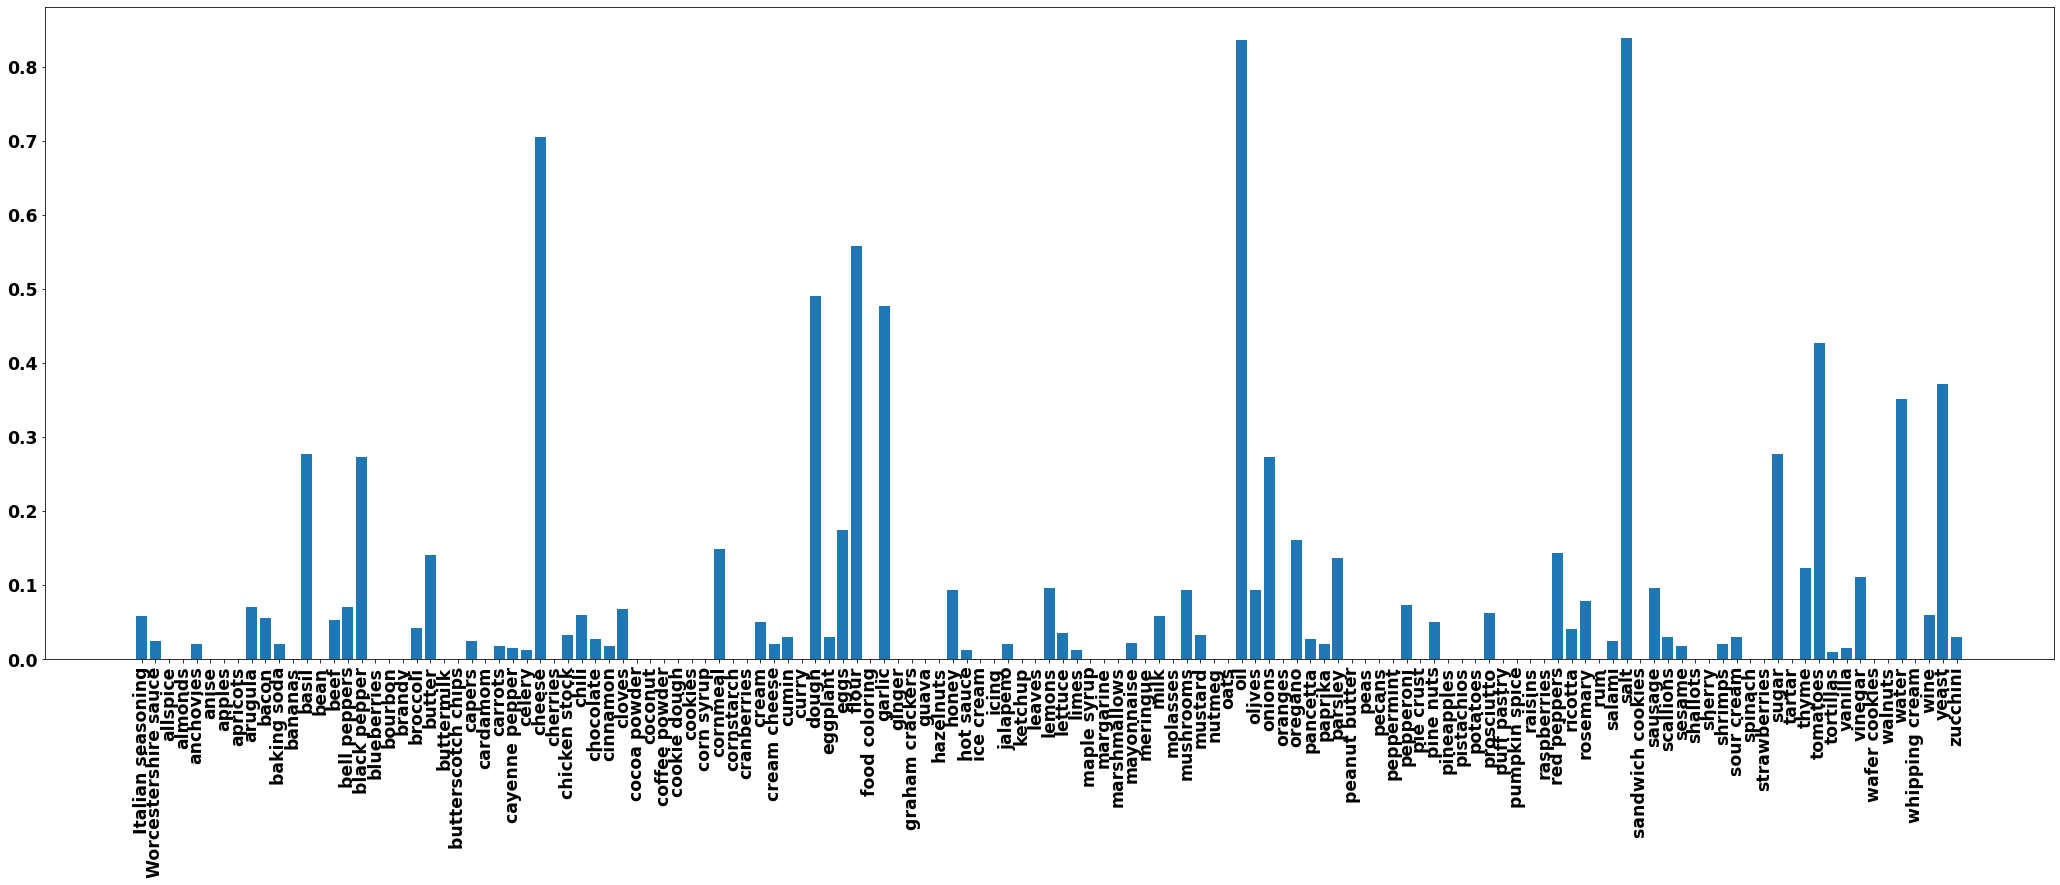

In [8]:
df_pizzas=X.loc[y=='Pizzas',:]

plt.figure(figsize=(36, 12))
plt.bar(np.arange(len(df_pizzas.columns)), df_pizzas.sum()/len(df_pizzas.index))
ind = np.argsort(df_pastries.sum())
plt.xticks(ind, df_pizzas.columns[ind], rotation='vertical', fontweight='bold', fontsize='xx-large')
plt.yticks(fontweight='bold', fontsize='xx-large')
plt.show()

# sir, testo, brasno, beli luk, ulje, so, paradajz
# brasno je svugde na ~0.65, to nam nista ne pomaze

In [9]:
# mozda klasifikator bude gledao i odsutnost sastojaka
# npr ni peciva ni kolaci nemaju uopste ruzmarin a pice imaju

In [10]:
def evaluation_classif(conf_mat):
    TP_c = conf_mat[0, 0]
    TN_c = conf_mat[1, 1] + conf_mat[1, 2] + conf_mat[2, 1] + conf_mat[2, 2]
    FP_c = conf_mat[1, 0] + conf_mat[2, 0]
    FN_c = conf_mat[0, 1] + conf_mat[0, 2]
    
    TP_p = conf_mat[1, 1]
    TN_p = conf_mat[0, 0] + conf_mat[0, 2] + conf_mat[2, 0] + conf_mat[2, 2]
    FP_p = conf_mat[0, 1] + conf_mat[2, 1]
    FN_p = conf_mat[1, 0] + conf_mat[1, 2]
    
    TP_z = conf_mat[2, 2]
    TN_z = conf_mat[0, 0] + conf_mat[0, 1] + conf_mat[1, 0] + conf_mat[1, 1]
    FP_z = conf_mat[0, 2] + conf_mat[1, 2]
    FN_z = conf_mat[2, 0] + conf_mat[2, 1]


    accuracy_c = (TP_c+TN_c)/(TP_c+TN_c+FP_c+FN_c)
    accuracy_p = (TP_p+TN_p)/(TP_p+TN_p+FP_p+FN_p)
    accuracy_z = (TP_z+TN_z)/(TP_z+TN_z+FP_z+FN_z)
    accuracy = (accuracy_c + accuracy_p + accuracy_z)/3
    print('tacnost klase kolaci: ', accuracy_c)
    print('tacnost klase peciva: ', accuracy_p)
    print('tacnost klase pice: ', accuracy_z)
    print('tacnost klasifikatora: ', accuracy)
    
    '''
    precision = TP/(TP+FP) 
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    F_score = 2*precision*sensitivity/(precision+sensitivity)
    print('preciznost: ', precision)
    print('osetljivost/odziv: ', sensitivity)
    print('specificnost: ', specificity)
    print('F skor: ', F_score)
    '''

In [11]:
# podela podataka na trening i test
X_train = X
y_train = y

df_test = pd.read_csv('cookies_test.csv')
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]
print(df_test.shape)
# ista podela podataka kao i kod trening skupa

(193, 134)


In [12]:
print('uzoraka u prvoj klasi ima: ', sum(y_test=='Cookies'))
print('uzoraka u drugoj klasi ima: ', sum(y_test=='Pastries'))
print('uzoraka u trecoj klasi ima: ', sum(y_test=='Pizzas'))

# poklapa se sa sumama vrsta matrice konfuzije

uzoraka u prvoj klasi ima:  80
uzoraka u drugoj klasi ima:  69
uzoraka u trecoj klasi ima:  44


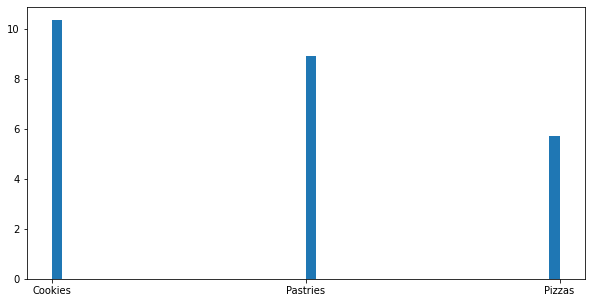

In [23]:
plt.figure(figsize=(10,5))
plt.hist(y_test, density=True, bins=50)
plt.show()

In [13]:
# KNN

In [25]:
# unakrasna validacija
# validaciju radimo na trening skupu, podelimo na 10 delova, istestiramo 

# StratifiedKFold nam pomaze u ocuvanju  zastupljenosti svake klase, tako da smo taj problem sad resili
# n_splits = 10 - podela na 10 podskupova

skf = StratifiedKFold(n_splits= 10, shuffle=True, random_state=17)
indexes = skf.split(X, y)
fin_conf_mat = np.zeros((len(np.unique(y)),len(np.unique(y))))
for train_index, test_index in indexes:
    X_train1, X_test1  = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train1, y_test1 = y.iloc[train_index], y.iloc[test_index]
    
    # u sklearn.neighbors.DistanceMetric treba da se odaberu odgovarajuce metrike
    # za binarna obelezja se preporucuje Zakarova i Dajsova metrika

    # ['jaccard', 'dice', 'kulsinski', 'matching', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath']:
    # jaccard i dice daju skoro pa identicne rezultate, koristicemo samo jedan
    # najbolje rezultate dobijamo sa k=1 i jaccard/kulsinski metrikom
    # russellrao daje najgore rezultate
    for m in ['jaccard', 'kulsinski', 'sokalsneath']:
        error = []
        for i in range(1, 10): # rastojanje od 1 do 10 suseda

            knn_klasifikator = KNeighborsClassifier(n_neighbors=i, metric=m) # inicijalizacija klasifikatora
            knn_klasifikator.fit(X_train1, y_train1) # obuka
            y_pred = knn_klasifikator.predict(X_test1) # testiranje
            error.append(accuracy_score(y_test1, y_pred))

        
        #plt.figure(figsize=(12, 6))
        #plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
        #plt.title('Error Rate for ' + m)
        #plt.xlabel('K Value')
        #plt.ylabel('Accuracy')
        
    classifier = KNeighborsClassifier(n_neighbors=1, metric='kulsinski')
    classifier.fit(X_train1, y_train1)
    y_pred = classifier.predict(X_test1)
    conf_mat = confusion_matrix(y_test1, y_pred)
    #print(conf_mat)
    #print(accuracy_score(y_test1, y_pred))
    fin_conf_mat += conf_mat

print('finalna matrica je: ')
print(np.transpose(fin_conf_mat))
evaluation_classif(np.transpose(fin_conf_mat))

finalna matrica je: 
[[652.  49.   7.]
 [ 67. 550.  15.]
 [  4.  20. 374.]]
tacnost klase kolaci:  0.92692750287687
tacnost klase peciva:  0.9131185270425777
tacnost klase pice:  0.9735327963176065
tacnost klasifikatora:  0.9378596087456846


In [15]:
classifier = KNeighborsClassifier(n_neighbors=1, metric='kulsinski')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(np.transpose(conf_mat))
evaluation_classif(np.transpose(conf_mat))
print('\n')

#print('osetljivost/odziv: ', recall_score(y_test, y_pred), average='macro')
#print('specificnost: ', specificity_score(y_test, y_pred))
print('preciznost mikro: ', precision_score(y_test, y_pred, average='micro'))
print('preciznost makro: ', precision_score(y_test, y_pred, average='macro'))
print('f mera mikro: ', f1_score(y_test, y_pred, average='micro'))
print('f mera makro: ', f1_score(y_test, y_pred, average='macro'))

recall_score, accuracy_score, roc_curve, precision_recall_curve

[[77  5  1]
 [ 3 63  3]
 [ 0  1 40]]
tacnost klase kolaci:  0.9533678756476683
tacnost klase peciva:  0.9378238341968912
tacnost klase pice:  0.9740932642487047
tacnost klasifikatora:  0.9550949913644214


preciznost mikro:  0.9326424870466321
preciznost makro:  0.9387880259106415
f mera mikro:  0.9326424870466321
f mera makro:  0.9330017416409081


(<function sklearn.metrics._classification.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>,
 <function sklearn.metrics._ranking.roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)>,
 <function sklearn.metrics._ranking.precision_recall_curve(y_true, probas_pred, *, pos_label=None, sample_weight=None)>)

In [16]:
'''finalna matrica je: 
[[652.  49.   7.]
 [ 67. 550.  15.]
 [  4.  20. 374.]]
tacnost klase kolaci:  0.92692750287687
tacnost klase peciva:  0.9131185270425777
tacnost klase pice:  0.9735327963176065
tacnost klasifikatora:  0.9378596087456846

[[77  5  1]
 [ 3 63  3]
 [ 0  1 40]]
tacnost klase kolaci:  0.9533678756476683
tacnost klase peciva:  0.9378238341968912
tacnost klase pice:  0.9740932642487047
tacnost klasifikatora:  0.9550949913644214
'''

'finalna matrica je: \n[[652.  49.   7.]\n [ 67. 550.  15.]\n [  4.  20. 374.]]\ntacnost klase kolaci:  0.92692750287687\ntacnost klase peciva:  0.9131185270425777\ntacnost klase pice:  0.9735327963176065\ntacnost klasifikatora:  0.9378596087456846\n\n[[77  5  1]\n [ 3 63  3]\n [ 0  1 40]]\ntacnost klase kolaci:  0.9533678756476683\ntacnost klase peciva:  0.9378238341968912\ntacnost klase pice:  0.9740932642487047\ntacnost klasifikatora:  0.9550949913644214\n'

In [17]:
# LOGISTICKA RETGRESIJA

In [18]:
# unakrasna validacija

skf = StratifiedKFold(n_splits= 10, shuffle=True, random_state=17)
indexes = skf.split(X, y)
fin_conf_mat = np.zeros((len(np.unique(y)),len(np.unique(y))))
for train_index, test_index in indexes:
    X_train2, X_test2  = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train2, y_test2 = y.iloc[train_index], y.iloc[test_index]
    
    acc = []
    for num in [100, 200, 500, 1000]:
        for solv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
            classifier = LogisticRegression(max_iter=num, solver=solv)
            classifier.fit(X_train2, y_train2)
            y_pred = classifier.predict(X_test2)  
            #print('za parametre ', num, ' i ', solv, ' tacnost je: ', accuracy_score(y_test2, y_pred)) 
            acc.append(accuracy_score(y_test2, y_pred))
    #print('najbolja preciznost je u iteraciji broj: ', np.argmax(acc))
    #print('\n')
    
    classifier = LogisticRegression(max_iter=100, solver='sag')
    classifier.fit(X_train2, y_train2)
    y_pred = classifier.predict(X_test2) 
    conf_mat = confusion_matrix(y_test2, y_pred)
    fin_conf_mat += conf_mat

print('finalna matrica je: ')
print(np.transpose(fin_conf_mat))
evaluation_classif(np.transpose(fin_conf_mat))

finalna matrica je: 
[[682.  83.   5.]
 [ 41. 527.  11.]
 [  0.   9. 380.]]
tacnost klase kolaci:  0.9257767548906789
tacnost klase peciva:  0.9171461449942463
tacnost klase pice:  0.9856156501726122
tacnost klasifikatora:  0.9428461833525125


In [ ]:
'''
finalna matrica je: 
[[652.  49.   7.]
 [ 67. 550.  15.]
 [  4.  20. 374.]]
tacnost klase kolaci:  0.92692750287687
tacnost klase peciva:  0.9131185270425777
tacnost klase pice:  0.9735327963176065
tacnost klasifikatora:  0.9378596087456846

finalna matrica je: 
[[682.  83.   5.]
 [ 41. 527.  11.]
 [  0.   9. 380.]]
tacnost klase kolaci:  0.9257767548906789
tacnost klase peciva:  0.9171461449942463
tacnost klase pice:  0.9856156501726122
tacnost klasifikatora:  0.9428461833525125
'''

In [19]:
classifier = LogisticRegression(max_iter=100, solver='lbfgs')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) 
conf_mat = confusion_matrix(y_test, y_pred) 
print(np.transpose(conf_mat))
evaluation_classif(np.transpose(conf_mat))
wrong_predicted = (y_test != y_pred)
print('\nprocenat sigurnosti u pogresnim: ', classifier.predict_proba(X_test.loc[wrong_predicted,:]).max(axis=0).mean())
print('prosecno siguran u ispravnim: ', classifier.predict_proba(X_test.loc[~wrong_predicted,:]).max(axis=0).mean())
print('\n')
#print('osetljivost/odziv: ', precision_score(y_test, y_pred))
#print('specificnost: ', specificity_score(y_test, y_pred))
print('preciznost mikro: ', precision_score(y_test, y_pred, average='micro'))
print('preciznost makro: ', precision_score(y_test, y_pred, average='macro'))
print('f mera mikro: ', f1_score(y_test, y_pred, average='micro'))
print('f mera makro: ', f1_score(y_test, y_pred, average='macro'))

[[75  3  2]
 [ 5 65  0]
 [ 0  1 42]]
tacnost klase kolaci:  0.9481865284974094
tacnost klase peciva:  0.9533678756476683
tacnost klase pice:  0.9844559585492227
tacnost klasifikatora:  0.9620034542314335

procenat sigurnosti u pogresnim:  0.7513636146149502
prosecno siguran u ispravnim:  0.9997943972400746


preciznost mikro:  0.9430051813471503
preciznost makro:  0.9476052048726468
f mera mikro:  0.9430051813471503
f mera makro:  0.9460896799801538


In [20]:

'''
finalna matrica je: 
[[682.  83.   5.]
 [ 41. 527.  11.]
 [  0.   9. 380.]]
tacnost klase kolaci:  0.9257767548906789
tacnost klase peciva:  0.9171461449942463
tacnost klase pice:  0.9856156501726122
tacnost klasifikatora:  0.9428461833525125

[[75  3  2]
 [ 5 65  0]
 [ 0  1 42]]
tacnost klase kolaci:  0.9481865284974094
tacnost klase peciva:  0.9533678756476683
tacnost klase pice:  0.9844559585492227
tacnost klasifikatora:  0.9620034542314335
'''

In [21]:
df = pd.read_excel('rezultati.xlsx')
df.head()

,klasifikator,tacnost klase kolaci,tacnost klase peciva,tacnost klase pice,prosecna tacnost klasifikatora,mikro preciznost,makro preciznost,mikro F mera,makro F mera
0,knn,0.953,0.937,0.974,0.955,0.932,0.938,0.932,0.933
1,logisticka,0.948,0.953,0.984,0.962,0.943,0.947,0.943,0.946
